In [31]:
#Import the libraries we need
import pandas              as pd
import numpy               as np
import seaborn             as sns
import matplotlib.pyplot   as plt
import MetaTrader5         as mt5
from   scipy.optimize      import minimize

In [2]:
#Initialize the terminal
mt5.initialize()

True

In [3]:
#Now let us fetch the data we need on chip manufacturing stocks
#Broadcom, Cisco, Comcast, Intel, NVIDA
stocks = ["AVGO.NAS","CSCO.NAS","CMCSA.NAS","INTC.NAS","NVDA.NAS"]

In [10]:
#Let us create a data frame to store our stock returns
amount = 100000
returns = pd.DataFrame(columns=stocks,index=np.arange(0,amount))

In [11]:
#Fetch the stock returns
for stock in stocks:
    temp = pd.DataFrame(mt5.copy_rates_from_pos(stock,mt5.TIMEFRAME_M1,0,amount))
    returns[[stock]] = temp[["close"]].pct_change()

In [13]:
#Format the data set 
returns.dropna(inplace=True)
returns.reset_index(inplace=True,drop=True)
returns

AVGO.NAS  CSCO.NAS  CMCSA.NAS  INTC.NAS  NVDA.NAS
0      0.000091 -0.000180   0.000000 -0.000307  0.000476
1      0.000567 -0.000180   0.000000  0.000000  0.000000
2      0.000906 -0.000180   0.000438  0.000308  0.000238
3     -0.000475  0.000361   0.000219 -0.000307 -0.001188
4     -0.000759  0.000180   0.000875  0.000308  0.000714
...         ...       ...        ...       ...       ...
99994  0.001294  0.000395   0.000255 -0.000320 -0.002836
99995  0.001108  0.000593   0.000000  0.000640 -0.000622
99996  0.000430 -0.000395  -0.000255  0.000639  0.001245
99997  0.000184 -0.000198   0.000255 -0.000319 -0.000622
99998 -0.000922 -0.000395   0.000510 -0.003196 -0.000622

[99999 rows x 5 columns]

In [63]:
#Convert the returns to percentages
returns = returns * 100
returns

AVGO.NAS  CSCO.NAS  CMCSA.NAS  INTC.NAS  NVDA.NAS
0      0.009071 -0.018028   0.000000 -0.030741  0.047574
1      0.056687 -0.018031   0.000000  0.000000  0.000000
2      0.090647 -0.018034   0.043754  0.030750  0.023776
3     -0.047547  0.036075   0.021867 -0.030741 -0.118850
4     -0.075885  0.018031   0.087451  0.030750  0.071395
...         ...       ...        ...       ...       ...
99994  0.129422  0.039541   0.025491 -0.031980 -0.283613
99995  0.110790  0.059289   0.000000  0.063980 -0.062217
99996  0.043037 -0.039502  -0.025484  0.063939  0.124511
99997  0.018437 -0.019759   0.025491 -0.031949 -0.062178
99998 -0.092166 -0.039526   0.050968 -0.319591 -0.062217

[99999 rows x 5 columns]

<Axes: >

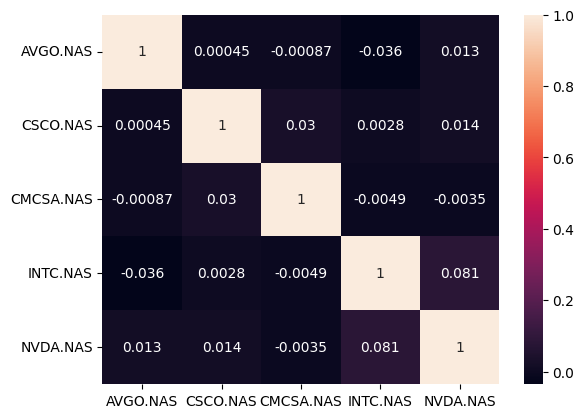

In [14]:
#Let's analyze if there is any correlation in the data
sns.heatmap(returns.corr(),annot=True)

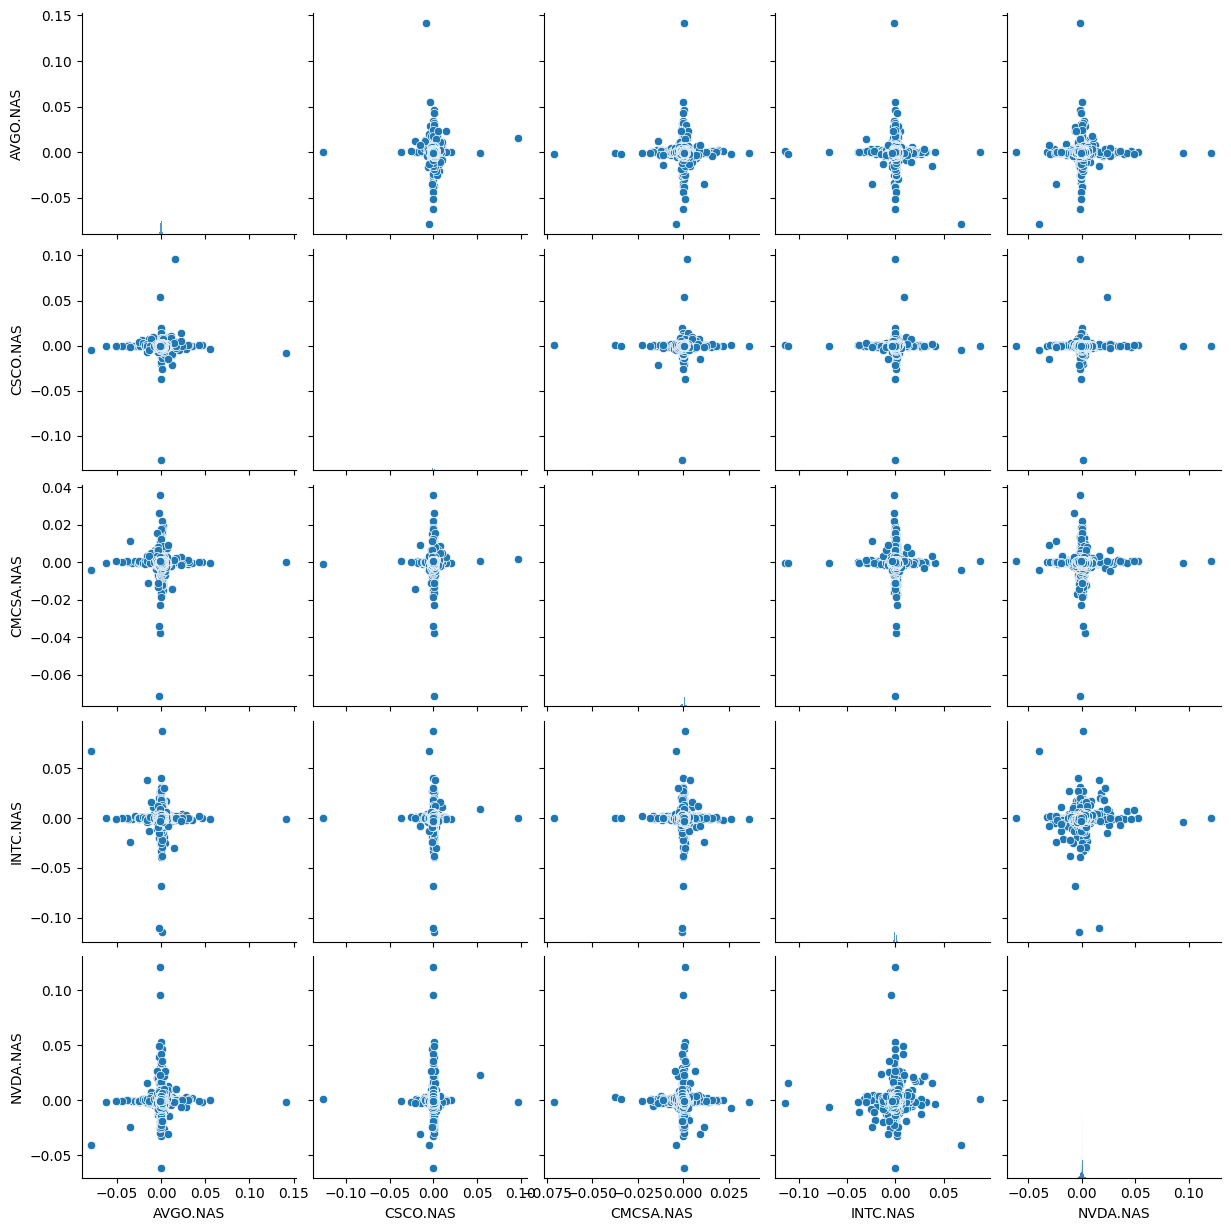

In [15]:
#Let's create pair plots of our data
sns.pairplot(returns)

<Axes: >

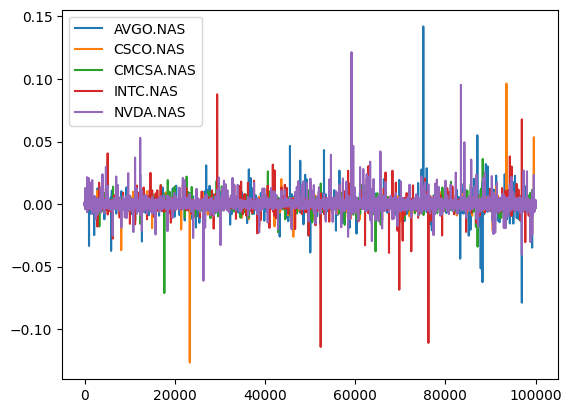

In [17]:
#Lets also visualize our returns
returns.plot()

<Axes: >

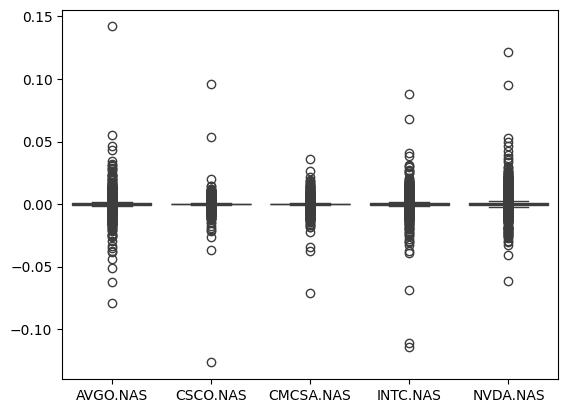

In [18]:
#Let's try creating box-plots 
sns.boxplot(returns)

In [87]:
#Define random weights that add up to 1
weights = np.array([1,0.5,0,0.5,-1])
#Create a data structure to store the progress of the algorithm
evaluation_history = []

In [88]:
#Let us now get ready to maximize our returns
#First we need to define the cost function
def cost_function(x):
    #First we need to calculate the portfolio returns with the suggested weights
    portfolio_returns = np.dot(returns,x)
    geom_mean         =  ((np.prod( 1 + portfolio_returns ) ** (1.0/99999.0)) - 1)
    #Let's keep track of how our algorithm is performing
    evaluation_history.append(-geom_mean)
    return(-geom_mean)

In [89]:
#Now we need to define our constraints
def l1_norm_constraint(x):
    return(((np.sum(np.abs(x))) - 1))

constraints = ({'type':'eq','fun':l1_norm_constraint})

In [90]:
#Now we need to define the bounds for our weights
bounds = [(-1,1)] * 5

In [91]:
#Perform the optimization
results = minimize(cost_function,weights,method="SLSQP",bounds=bounds,constraints=constraints)

C:\users\volatily\Temp\ipykernel_472\1499534289.py:6: RuntimeWarning: invalid value encountered in scalar power
  geom_mean         =  ((np.prod( 1 + portfolio_returns ) ** (1.0/99999.0)) - 1)


In [92]:
results

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 0.0024308603411499208
       x: [ 3.931e-01  1.138e-01 -5.991e-02  7.744e-02 -3.557e-01]
     nit: 23
     jac: [ 3.851e-04  2.506e-05 -3.083e-04 -6.868e-05 -3.186e-04]
    nfev: 158
    njev: 23

In [94]:
optimal_weights = results.x
optimal_weights

array([ 0.39311134,  0.11379942, -0.05991417,  0.07743534, -0.35573973])

In [104]:
optima_y = min(evaluation_history)
optima_x = evaluation_history.index(optima_y)

In [99]:
inputs = np.arange(0,len(evaluation_history))

Text(0.5, 1.0, 'Maximizing Returns')

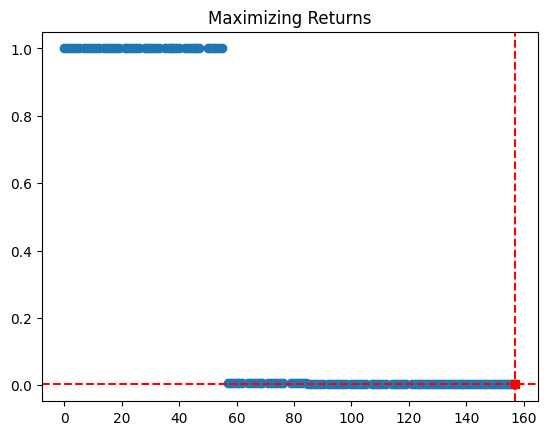

In [109]:
plt.scatter(inputs,evaluation_history)
plt.plot(optima_x,optima_y,'s',color='r')
plt.axvline(x=optima_x,ls='--',color='red')
plt.axhline(y=optima_y,ls='--',color='red')
plt.title("Maximizing Returns")

In [114]:
#Validate the weights add up to 1
np.sum(np.abs(optimal_weights))

1.0

In [118]:
#Here's an intuitive way of understanding the data
#If we can only open 10 positions, our best bet may be
#3 buy positions in Broadcom
#1 buy position in Cisco
#1 sell position sell position in Comcast
#No positions in Intel
#4 sell postions in NVIDIA
(optimal_weights * 10) // 1

array([ 3.,  1., -1.,  0., -4.])